# Memory experiment: Compute $ \langle \bar{0} | \bar{Z} | \bar{0} \rangle$ with the five-qubit code

In [1]:
import collections
from typing import List, Dict, Sequence
import itertools
import functools

import numpy as np
import cirq
import qiskit
from qiskit.circuit.library import Barrier
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

from mitiq import PauliString
import stim
import stimcirq

from encoded.diagonalize import get_stabilizer_matrix_from_paulis, get_measurement_circuit, get_paulis_from_stabilizer_matrix

In [2]:
import datetime


time_key = datetime.datetime.now().strftime("%m_%d_%Y_%H:%M:%S")  # For saving results.

## Set parameters

In [3]:
n = 5                                   # Number of physical qubits
nshots = 20_000                         # Number of samples/shots
depths = np.arange(0, 100 + 1, 10)      # Number of X (NOT) gates to perform (each depth should be even to implement a noisy identity)
k = 1                                   # Number of logical qubits.

In [4]:
# Computer and qubits to use.
service = qiskit_ibm_runtime.QiskitRuntimeService()  # This assumes a saved account.
computer = service.backend("ibm_kyiv")
sampler = Sampler(computer)

# See calibration data at https://quantum.ibm.com/services/resources to select good qubits.
layout = {
    5: [14, 0, 1, 2, 3]
    # 7: [99, 100, 101, 110, 117, 118, 119]
    # 7 : [3, 2, 1, 0, 14, 18, 19],
}


# Good qubits in Sherbrooke Jan 24.
# layout = {
#     7 : [99, 100, 101, 110, 117, 118, 119],
# }

## Helper functions

In [5]:
def get_counts_for(qubit: int, counts: collections.Counter[str, int]) -> collections.Counter[int, int]:
    qubit_counts = collections.Counter()
    for key, value in counts.items():
        k = list(key)[qubit]
        qubit_counts[int(k)] += value
    return qubit_counts


# Expectation of pauli on bitstring measured in diagonal basis.
def compute_expectation(
    pauli: cirq.PauliString,
    counts: Dict[str, int],
) -> float:
    if pauli is cirq.PauliString():
        return 1.0

    expectation = 0.0

    indices = [q.x for q in pauli.qubits]
    for key, value in counts.items():
        key = list(map(int, list(key[::-1])))
        expectation += (-1) ** sum([key[i] for i in indices]) * value

    return expectation / sum(counts.values())

def parity_check_matrix_to_stabilizers(matrix: np.ndarray) -> List[stim.PauliString]:
    num_rows, num_cols = matrix.shape
    assert num_cols % 2 == 0
    num_qubits = num_cols // 2

    matrix = matrix.astype(np.bool8)  # indicate the data isn't bit packed
    return [
        stim.PauliString.from_numpy(
            xs=matrix[row, :num_qubits],
            zs=matrix[row, num_qubits:],
        )
        for row in range(num_rows)
    ]


def stabilizers_to_encoder(stabilizers) -> stim.Circuit:
    
    tableau = stim.Tableau.from_stabilizers(
        stabilizers,
        allow_underconstrained=True,
    )
    return tableau.to_circuit(method='graph_state')



# Prepares logical |0> state on Steane Code
def encode_five(qreg: Sequence[cirq.Qid]) -> cirq.Circuit:
    a= stim.PauliString("+ZX_XZ")
    b=stim.PauliString("+XZZX_")
    c= stim.PauliString("+_XZZX")
    d=stim.PauliString("+X_XZZ")
    test_encoder1 = stabilizers_to_encoder([a, b, c, d])
    circuit =stimcirq.stim_circuit_to_cirq_circuit(test_encoder1) 
    circuit.append(cirq.X.on_each(qreg))
    
    return circuit

def noisy_identity(qreg, depth):
    circuit = cirq.Circuit()
    if depth == 0:
        circuit.append(cirq.I.on_each(qreg))
    for _ in range(depth):
        circuit.append(cirq.X.on_each(qreg))
    return circuit

def strs_to_paulis(pauli_strs : List[str]) -> List[cirq.PauliString]:
    stab_list = []
    for stab_str in pauli_strs:
        stab_list.append(PauliString(stab_str)._pauli)
    return stab_list

def generate_stabilizer_elements(generators: List[cirq.PauliString]) -> List[cirq.PauliString]:
    elements = []
    for string in itertools.chain.from_iterable(itertools.combinations(generators, r) for r in range(len(generators) + 1)):
        elements.append(
            functools.reduce(lambda a, b: a * b, string, cirq.PauliString())
        )
    return elements

# For qiskit circuits
def get_active_qubits(circ):
    dag = qiskit.converters.circuit_to_dag(circ)
    active_qubits = [qubit for qubit in circ.qubits if qubit not in dag.idle_wires()]
    return active_qubits

def get_lst_ev(counts, observables, stabilizers):
    numerator = 0
    for obs in observables:
        numerator += compute_expectation(obs, counts) / len(observables)
    denominator = 0
    for stab in stabilizers:
        denominator += compute_expectation(stab, counts) / len(stabilizers)
    return float(np.real_if_close(numerator / denominator))

### Run unmitigated experiment

In [6]:
qreg = cirq.LineQubit.range(n)

to_run_raw = []
for depth in depths:
    circuit = noisy_identity(qreg, depth)

    circuit = qiskit.QuantumCircuit.from_qasm_str(circuit.to_qasm())
    circuit.measure_active()
    # Compile to device.
    compiled_raw = qiskit.transpile(
        circuit, 
        backend=computer,
        initial_layout=layout[n],
        routing_method="sabre",
        # scheduling_method="asap",
        optimization_level=0,
    )
    to_run_raw.append(compiled_raw)

In [7]:
to_run_raw[-1].draw(fold=-1, idle_wires=False)

┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐ ░    ┌─┐         
  q_1 -> 0 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░────┤M├─────────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░    └╥┘┌─┐      
  q_2 -> 1 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─────╫─┤M├──────
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░     ║ └╥┘┌─┐   
  q_3 -> 2 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├─░─────╫──╫─┤M├───
           ├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤├───┤ ░     ║  ║ └╥┘┌─┐
  q_4 -> 3 ┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├

In [8]:
job_raw = sampler.run(
    to_run_raw,
    shots=nshots,
)
# job_raw = service.job("cuajqngtk14s73b60ms0")

In [9]:
all_counts_raw = [result.data.measure.get_counts() for result in job_raw.result()]

In [10]:
all_evals = {}

for i, q in enumerate(layout[n]):
    evals = []
    for counts in all_counts_raw:
        counts = get_counts_for(i, counts)
        eval = (counts.get(0, 0) - counts.get(1, 0)) / nshots
        evals.append(eval)
    all_evals[q] = evals

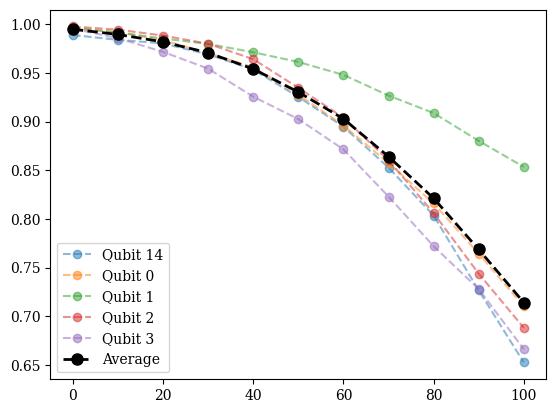

In [11]:
for qubit, evals in all_evals.items():
    plt.plot(depths, evals, "--o", alpha=0.5, label=f"Qubit {qubit}")

evals_raw_avg = np.array(list(all_evals.values())).mean(axis=0)
plt.plot(depths, evals_raw_avg, "--o", ms=8, lw=2, color="black", label="Average")
plt.legend();
plt.savefig("physical_evals.pdf")

# Run encoded experiment

In [12]:
generator_strs = [
    "XZZXI",
    "IXZZX",
    "XIXZZ", 
    "ZXIXZ"
]
observable = PauliString("Z" * n)._pauli

qreg = cirq.LineQubit.range(n)

stabilizer_generators = strs_to_paulis(generator_strs)
stabilizer_matrix = get_stabilizer_matrix_from_paulis(stabilizer_generators, qreg)
measurement_circuit, transformed_matrix = get_measurement_circuit(stabilizer_matrix)

transformed_generators = get_paulis_from_stabilizer_matrix(transformed_matrix)
stabilizer_elements = generate_stabilizer_elements(transformed_generators)
# for stab in stabilizer_elements:
#     print(stab)

transformed_observable = observable.conjugated_by(measurement_circuit**-1)
observable_elements = [transformed_observable * stab for stab in stabilizer_elements]
# for obs in observable_elements:
#     print(obs)
# print(measurement_circuit)


In [13]:
encoding = encode_five(qreg)
encoding = qiskit.QuantumCircuit.from_qasm_str(encoding.to_qasm())

measurement = qiskit.QuantumCircuit.from_qasm_str(measurement_circuit.to_qasm())

circ_full = encoding.compose(
        Barrier(n, label="encoding"), get_active_qubits(encoding)
    ).compose(Barrier(n, label="measurement"), get_active_qubits(encoding)
).compose(measurement)
circ_full.measure_active()

compiled = qiskit.transpile(
    circ_full, 
    backend=computer,
    initial_layout=layout[n],
    routing_method="sabre",
    # scheduling_method="asap",
    optimization_level=3,
)

compiled.draw(fold=-1, idle_wires=False)
# compiled.count_ops()

global phase: 3π/4
                ┌─────────┐ ┌────┐             ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────────────┐┌────┐        ┌──────┐┌─────────┐ ┌────┐┌──────────┐        ┌──────┐   ┌────┐     ┌──────────┐                                                     ┌──────┐ ┌────────┐ ┌────┐                ┌──────┐┌──────────┐   ┌────┐   ┌────────┐┌──────┐ ┌─────────┐   ┌────┐ ┌─────────┐      ┌──────┐  ┌──────────┐ ┌────┐  ┌──────┐ ┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────┐┌──────────┐                                                                                                                                                              ░           ░      ┌──────────┐┌────┐┌─────────────┐┌──────┐┌────────────┐   ┌────┐                                                                                            ┌──────┐┌─────────┐ ┌────┐  ┌──────────┐ ┌──────┐   ┌────┐  ┌─────────────┐┌────┐┌──────┐┌─────────┐  ┌────┐ ┌──────────┐      ┌──────┐┌────────┐    ┌───┐                                                                                                                                                          ┌──────┐     ┌───┐   ┌──────────┐┌──────┐ ┌────────┐┌────┐   ┌────────┐  ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐ ┌────────┐ ┌────┐               ┌──────┐┌─────────────┐ ┌────┐                                                                                ┌──────┐  ┌─────────┐ ┌────┐┌──────────┐┌──────┐┌────────┐     ┌────┐     ┌──────┐┌──────────┐   ┌────┐   ┌─────────┐                     ░          ┌─┐   
  q_1 -> 0 ─|0>─┤ Rz(π/2) ├─┤ √X ├─────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(1.0927) ├┤ √X ├────────┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├────────┤0     ├───┤ √X ├─────┤ Rz(-π/2) ├─────────────────────────────────────────────────────┤0     ├─┤ Rz(-π) ├─┤ √X ├────────────────┤0     ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├─┤ Rz(π/2) ├───┤ √X ├─┤ Rz(π/2) ├──────┤0     ├──┤ Rz(-π/2) ├─┤ √X ├──┤0     ├─┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ √X ├┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░───────────░──────┤ Rz(-π/2) ├┤ √X ├┤ Rz(-1.5131) ├┤0     ├┤ Rz(1.5544) ├───┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────┤0     ├┤ Rz(π/2) ├─┤ √X ├──┤ Rz(-π/2) ├─┤0     ├───┤ √X ├──┤ Rz(-2.7238) ├┤ √X ├┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├──────┤0     ├┤ Rz(-π) ├────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─────┤ X ├───┤ Rz(-π/2) ├┤0     ├─┤ Rz(-π) ├┤ √X ├───┤ Rz(-π) ├──┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├─┤ Rz(-π) ├─┤ √X ├───────────────┤0     ├┤ Rz(0.40668) ├─┤ √X ├────────────────────────────────────────────────────────────────────────────────┤0     ├──┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├┤0     ├┤ Rz(-π) ├─────┤ √X ├─────┤0     ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(π/2) ├─────────────────────░──────────┤M├───
                ├─────────┤ ├────┤  ┌────────┐ │  Ecr │├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │└─┬────────┬─┘├───┬┘┌──────┐│      │├─────────┴┐├────┤└┬────────┬┘┌──────┐│      │┌──┴────┴─┐   └──┬────┬──┘ ┌─────────┐┌──────┐┌─────────────┐┌────┐┌──────────┐│  Ecr │┌┴────────┴┐├────┤┌──────────────┐│      │└─┬──────┬─┘   └────┘   └────────┘│      │ └─────────┘   └────┘ └─────────┘      │      │  └──────────┘ └────┘  │  Ecr │ ├─────────┬┘├────┤└────────┘│  Ecr │├─────────┴┐└────┘└─────────┘│  Ecr │├───┬┘├──────────┤┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐   ┌────┐  ┌──────────┐                                    

In [14]:
to_run = []
for depth in depths:
    temp = compiled.copy_empty_like()
    for instruction in compiled.data:
        if instruction.label == "measurement":
            for _ in range(depth):
                for q in get_active_qubits(temp):
                    temp.x(q)
        temp.append(
            instruction, instruction.qubits
        )
    to_run.append(temp)

In [15]:
to_run[-1].draw(fold=-1, idle_wires=False)

global phase: 3π/4
                ┌─────────┐ ┌────┐             ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────────────┐┌────┐        ┌──────┐┌─────────┐ ┌────┐┌──────────┐        ┌──────┐   ┌────┐     ┌──────────┐                                                     ┌──────┐ ┌────────┐ ┌────┐                ┌──────┐┌──────────┐   ┌────┐   ┌────────┐┌──────┐ ┌─────────┐   ┌────┐ ┌─────────┐      ┌──────┐  ┌──────────┐ ┌────┐  ┌──────┐ ┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐┌────┐┌──────────┐                                                                                                                                                              ░     ┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐┌───┐      ░      ┌──────────┐┌────┐┌─────────────┐┌──────┐┌────────────┐   ┌────┐                                                                                            ┌──────┐┌─────────┐ ┌────┐  ┌──────────┐ ┌──────┐   ┌────┐  ┌─────────────┐┌────┐┌──────┐┌─────────┐  ┌────┐ ┌──────────┐      ┌──────┐┌────────┐    ┌───┐                                                                                                                                                          ┌──────┐     ┌───┐   ┌──────────┐┌──────┐ ┌────────┐┌────┐   ┌────────┐  ┌──────┐┌──────────┐┌────┐┌────────┐┌──────┐┌─────────┐ ┌────┐┌─────────┐┌──────┐ ┌────────┐ ┌────┐               ┌──────┐┌─────────────┐ ┌────┐                                                                                ┌──────┐  ┌─────────┐ ┌────┐┌──────────┐┌──────┐┌────────┐     ┌────┐     ┌──────┐┌──────────┐   ┌────┐   ┌─────────┐                     ░          ┌─┐   
  q_1 -> 0 ─|0>─┤ Rz(π/2) ├─┤ √X ├─────────────┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ Rz(1.0927) ├┤ √X ├────────┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(-π/2) ├────────┤0     ├───┤ √X ├─────┤ Rz(-π/2) ├─────────────────────────────────────────────────────┤0     ├─┤ Rz(-π) ├─┤ √X ├────────────────┤0     ├┤ Rz(-π/2) ├───┤ √X ├───┤ Rz(-π) ├┤0     ├─┤ Rz(π/2) ├───┤ √X ├─┤ Rz(π/2) ├──────┤0     ├──┤ Rz(-π/2) ├─┤ √X ├──┤0     ├─┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2) ├┤0     ├┤ √X ├┤ Rz(-π/2) ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────░─────┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├┤ X ├──────░──────┤ Rz(-π/2) ├┤ √X ├┤ Rz(-1.5131) ├┤0     ├┤ Rz(1.5544) ├───┤ √X ├────────────────────────────────────────────────────────────────────────────────────────────┤0     ├┤ Rz(π/2) ├─┤ √X ├──┤ Rz(-π/2) ├─┤0     ├───┤ √X ├──┤ Rz(-2.7238) ├┤ √X ├┤0     ├┤ Rz(π/2) ├──┤ √X ├─┤ Rz(-π/2) ├──────┤0     ├┤ Rz(-π) ├────┤ X ├──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤0     ├─────┤ X ├───┤ Rz(-π/2) ├┤0     ├─┤ Rz(-π) ├┤ √X ├───┤ Rz(-π) ├──┤0     ├┤ Rz(-π/2) ├┤ √X ├┤ Rz(-π) ├┤0     ├┤ Rz(π/2) ├─┤ √X ├┤ Rz(π/2)

In [16]:
to_run[-1].count_ops()

OrderedDict([('x', 507),
             ('rz', 163),
             ('sx', 97),
             ('ecr', 46),
             ('reset', 5),
             ('measure', 5),
             ('barrier', 3)])

In [17]:
job = sampler.run(
    to_run,
    shots=nshots,
)
# job = service.job("cuajqq0tk14s73b60n0g")

In [18]:
all_counts = [result.data.measure.get_counts() for result in job.result()]
evals_encoded = [get_lst_ev(counts, observable_elements, stabilizer_elements) for counts in all_counts]
evals_encoded

[0.8492307692307693,
 0.8336877924287538,
 0.8428042673633792,
 0.7846688166708016,
 0.7863486424765288,
 0.776982378854626,
 0.7333333333333334,
 0.6283315078495803,
 0.517724649629019,
 0.4293032786885244,
 0.2254840724547158]

## With DD

In [19]:
sampler.options.dynamical_decoupling.enable = True
sampler.options.dynamical_decoupling.sequence_type = "XpXm"

In [20]:
job_dd = sampler.run(
    to_run,
    shots=nshots,
)
# job_dd = service.job("cuajqq8tk14s73b60n20")

In [21]:
all_counts_dd = [result.data.measure.get_counts() for result in job_dd.result()]
evals_dd = [get_lst_ev(counts, observable_elements, stabilizer_elements) for counts in all_counts_dd]
evals_dd

[0.9868489719235987,
 0.9806218057921634,
 0.9759227711527542,
 0.972488038277512,
 0.963566388710712,
 0.9399117186387579,
 0.9080976863753216,
 0.8602808786460207,
 0.7967090189543845,
 0.6534226902824318,
 0.4549367769706753]

## Plot data

In [22]:
save_key = f"memory_five_qubit_code_zero_state_z_{computer.name}_{time_key}_job_raw_id_{job_raw.job_id()}_job_encoded_id_{job.job_id()}_job_encoded_dd_id_{job_dd.job_id()}"

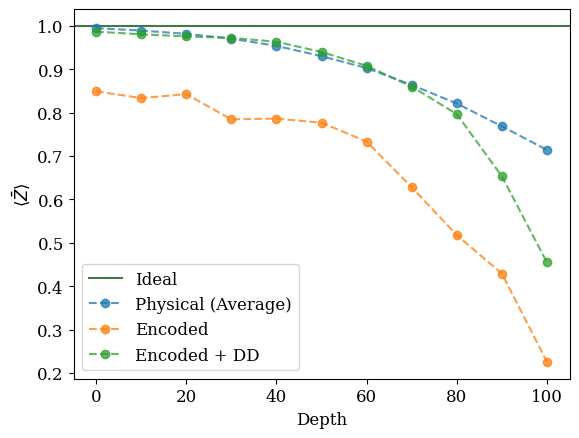

In [23]:
plt.rcParams.update({"font.family": "serif", "font.size": 12})
colors = ["xkcd:blue", "xkcd:orange", "xkcd:red"]
alpha: float = 0.75

plt.axhline(1.0, label="Ideal", alpha=alpha, color="xkcd:darkgreen")
plt.plot(depths, evals_raw_avg, "--o", alpha=alpha, label="Physical (Average)")
# plt.plot(depths, all_evals[121], "--o", alpha=alpha, label="Physical (Best)")
plt.plot(depths, evals_encoded, "--o", alpha=alpha, label="Encoded")
plt.plot(depths, evals_dd, "--o", alpha=alpha, label="Encoded + DD")

plt.ylabel(r"$\langle \bar{Z} \rangle$")
plt.xlabel("Depth")

plt.legend();
plt.savefig(save_key + ".pdf")

## Save all data

In [24]:
import os

import pickle

In [25]:
os.mkdir(save_key)

In [26]:
np.savetxt(f"{save_key}/physical_qubits.txt", layout[n])
np.savetxt(f"{save_key}/depths.txt", depths)

In [27]:
with open(f"{save_key}/expectation_values_raw.pkl", "wb") as f:
    pickle.dump(all_evals, f)

In [28]:
np.savetxt(f"{save_key}/expectation_values_encoded.txt", evals_encoded)
np.savetxt(f"{save_key}/expectation_values_encoded_dd.txt", evals_dd)